# Klasyfikacja niezbalansowana i anomaly detection

Poza standardowymi narzędziami do klasyfikacji tabelarycznej użyjemy bibliotek:
1. [Imbalanced-learn](https://imbalanced-learn.org/stable/index.html) - biblioteka implementująca różne algorytmy undersamplingu i oversamplingu
2. [PyOD](https://pyod.readthedocs.io/en/latest/index.html) - biblioteka implementująca mnóstwo algorytmów outlier detection
3. [XGBoost](https://xgboost.readthedocs.io/en/stable/) - oficjalna implementacja algorytmu XGBoost

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Klasyfikacja umiarkowanie niezbalansowana

Najpierw wykorzystamy zbiór danych [Polish companies bankruptcy](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data). Dotyczy on klasyfikacji, na podstawie danych z raportów finansowych, czy firma zbankrutuje w ciągu najbliższych kilku lat. Jest to zadanie szczególnie istotne dla banków, funduszy inwestycyjnych, firm ubezpieczeniowych itp., które z tego powodu zatrudniają licznie data scientistów. Zbiór zawiera 64 cechy, obliczone przez ekonomistów, którzy stworzyli ten zbiór, opisane na stronie UCI.

Wykorzystamy podzbiór, w którym na podstawie finansowych firmy po 3 latach monitorowania chcemy przewidywać, czy firma zbankrutuje w ciągu najbliższych 3 lat. Jest to dość realistyczny horyzont czasowy, a przy tym największy z podzbiorów.

In [40]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff("polish_companies_bankruptcy_3_year_data.arff")

df = pd.DataFrame(data[0])
y = df.pop("class").astype(int)

df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,127280.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375


**Zadanie 1 (1 punkt)**

1. Zwizualizuj brakujące ilość brakujących danych na wykresie słupkowym (bar plot).
2. Zwizualizuj rozkład klas na wykresie.

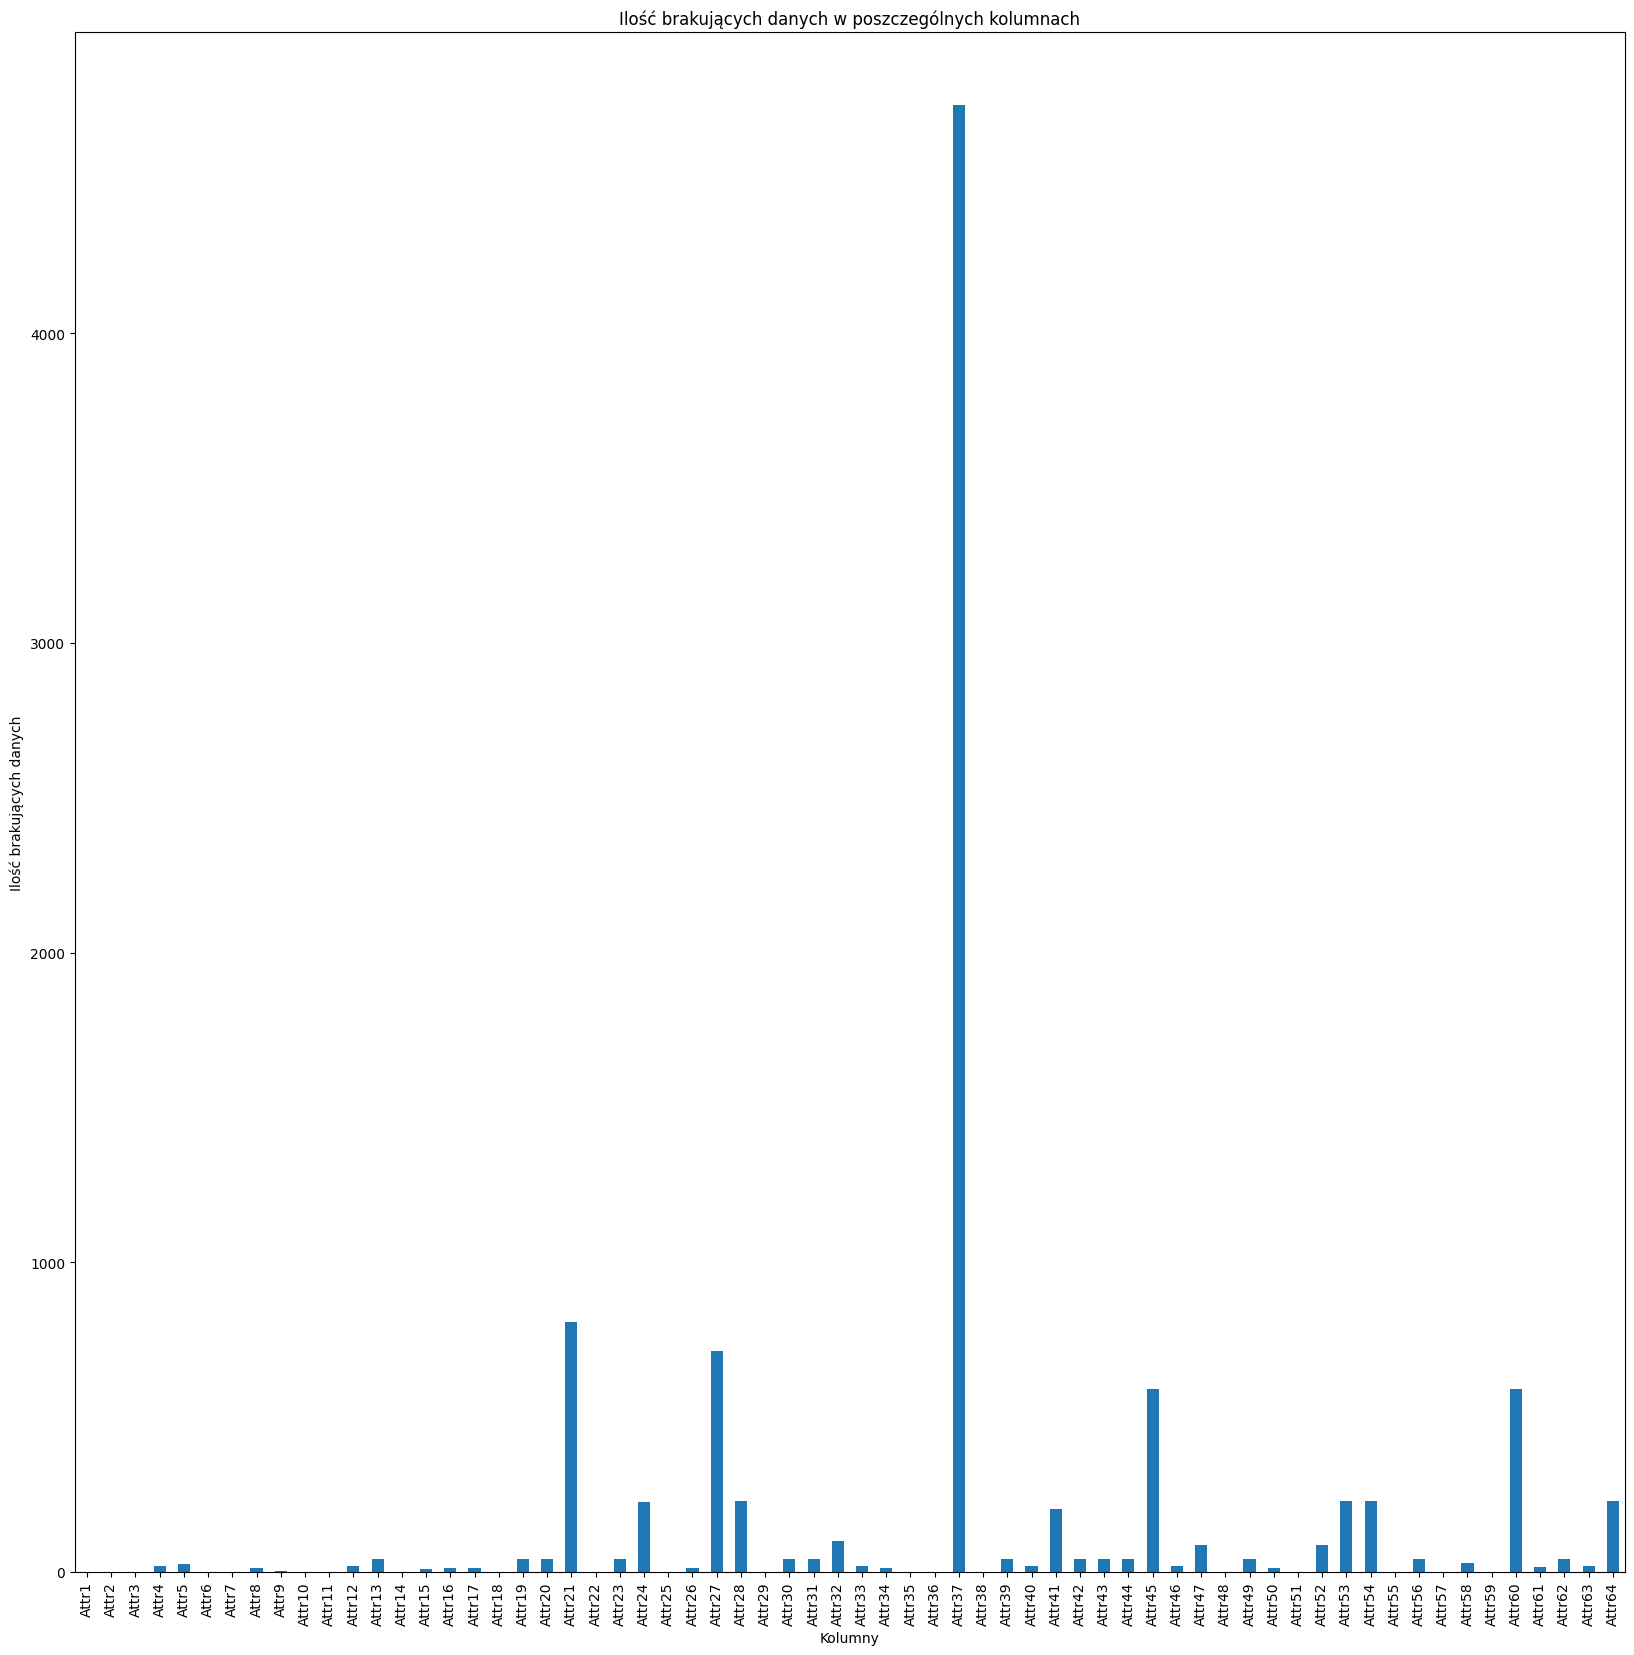

In [41]:
plt.figure(figsize=(20, 20))
missing_values = df.isnull().sum()
missing_values.plot(kind='bar')
plt.xlabel('Kolumny')
plt.ylabel('Ilość brakujących danych')
plt.title('Ilość brakujących danych w poszczególnych kolumnach')
plt.show()


3. Usuń cechę `Attr37`, mającą dużo wartości brakujących.


In [42]:
if 'Attr37' in df.columns:
    df.drop('Attr37', axis=1, inplace=True)
    print("Usunięto kolumnę Attr37")

Usunięto kolumnę Attr37


4. Dokonaj podziału na zbiór treningowy i testowy w proporcjach 75%-25%, ze stratyfikacją. Pamiętaj o `random_state=0`.
5. Zbuduj i zastosuj pipeline (`make_pipeline`) do czyszczenia danych, składający się z:
   - uzupełnienia wartości brakujących wartością średnią (`SimpleImputer`)
   - standaryzacji danych (`StandardScaler`)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=0, stratify=y)

pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

Standaryzacja była szczególnie ważna, bo metody undersamplingu i oversamplingu są oparte o najbliższych sąsiadów.

## Cost-sensitive learning i threshold tuning

Jako naszego algorytmu użyjemy lasu losowego (Random Forest). Dla przypomnienia, jest on oparty o **uczenie zespołowe (ensemble learning)**, w którym uśredniamy decyzje wielu klasyfikatorów bazowych. Są to drzewa decyzyjne. Losujemy w nim **próbki bootstrapowe (bootstrap samples)**, czyli losujemy z powtórzeniami tyle punktów, ile wynosi rozmiar naszego zbioru. Dla każdej losujemy także podzbiór cech, typowo tyle, ile wynosi pierwiastek kwadratowy z liczby wszystkich cech. Następnie trenujemy drzewa decyzyjne na takich wylosowanych podzbiorach. Decyzja klasyfikatora jest podejmowana przez głosowanie drzew (w klasyfikacji) lub ich uśrednienie (w regresji).

W wielu zastosowaniach dużą zaletą lasów losowych jest ich niska podatność na tuning hiperparametrów, tzw. **tunability**. Algorytmy o wysokim tunability (np. SVM) są podatne na dobór hiperparametrów i wymagają jego zastosowania, żeby osiągnąć dobre wyniki. Random Forest działa typowo doskonale z domyślnymi hiperparametrami, co najwyżej warto czasem ustawić większą liczbę drzew, niż domyślna. Ciekawe artykuły w tej kwestii to:

> Probst, Philipp, Anne-Laure Boulesteix, and Bernd Bischl. *"Tunability: Importance of hyperparameters of machine learning algorithms."* The Journal of Machine Learning Research 20.1 (2019): 1934-1965. [link](https://www.jmlr.org/papers/volume20/18-444/18-444.pdf)

> Probst, Philipp, Marvin N. Wright, and Anne‐Laure Boulesteix. *"Hyperparameters and tuning strategies for random forest."* Wiley Interdisciplinary Reviews: data mining and knowledge discovery 9.3 (2019): e1301. [link](https://arxiv.org/pdf/1804.03515.pdf)

Dzięki wykorzystaniu Random Forest zasadniczo nie będziemy potrzebować tuningu hiperparametrów dla klasyfikatora. Nadaje się też dobrze do klasyfikacji niezbalansowanej: drzewa decyzyjne łatwo integrują ważenie klas w proces treningu, a uśrednianie decyzji mocno zmniejsza wariancję błędu.

Ze względu na niezbalansowanie zbioru, które jest znaczące, ale nie ekstremalne, wykorzystamy dwie metryki: AUROC oraz F1-score. Ta druga będzie przydatna przy **threshold tuningu**.

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score


clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)
y_pred_score = clf_rf.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_score)
f1 = f1_score(y_test, y_pred)

print(f"AUROC: {100 * auroc:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

AUROC: 87.39%
F1-score: 31.37%


AUROC wydaje się niezłe, ale F1-score pozostawia wiele do życzenia. Zobaczmy, czy **cost-sensitive learning** coś zmieni. Skorzystamy z domyślnej heurystyki do ważenia klas `"balanced"`.

In [47]:
clf_rf_csl = RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1)
clf_rf_csl.fit(X_train, y_train)

y_pred = clf_rf_csl.predict(X_test)
y_pred_score = clf_rf_csl.predict_proba(X_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred_score)
f1 = f1_score(y_test, y_pred)

print(f"AUROC: {100 * auroc:.2f}%")
print(f"F1-score: {100 * f1:.2f}%")

AUROC: 89.30%
F1-score: 28.00%


Jedna metryka rośnie, druga maleje - tak też się może zdarzyć. Takie sytuacje są zawsze ciekawe, bo pokazują różne aspekty tego, jak radzi sobie nasz klasyfikator. F1-score łączy precyzję i czułość, więc warto przeanalizować to głębiej.

In [48]:
from sklearn.metrics import precision_score, recall_score

print("RF")
rf_precision = precision_score(y_test, clf_rf.predict(X_test))
rf_recall = recall_score(y_test, clf_rf.predict(X_test))
print(f"  Precision: {100 * rf_precision:.2f}%")
print(f"  Recall: {100 * rf_recall:.2f}%")

print()

print("RF with cost-sensitive learning")
rf_csl_precision = precision_score(y_test, clf_rf_csl.predict(X_test))
rf_csl_recall = recall_score(y_test, clf_rf_csl.predict(X_test))
print(f"  Precision: {100 * rf_csl_precision:.2f}%")
print(f"  Recall: {100 * rf_csl_recall:.2f}%")

RF
  Precision: 82.76%
  Recall: 19.35%

RF with cost-sensitive learning
  Precision: 80.77%
  Recall: 16.94%


Z cost-sensitive learningiem predykcje prawdopodobieństwa co prawda są lepsze (bo mamy wyższy AUROC), ale i precyzja, i czułość spadły. No i w obu przypadkach mamy naprawdę niski recall!

Coś trzeba z tym zrobić. Skoro F1-score to metryka binarna, to najłatwiej zmienić próg klasy pozytywnej, czyli zrobić threshold tuning.

**Zadanie 2 (1.5 punktu)**

Zaimplementuj threshold tuning z pomocą walidacji skrośnej. Skorzystaj z funkcji `thresholded_f1_score()`, która jest gotową metryką, obliczającą F1-score dla podanych prawdopodobieństw klasy pozytywnej i progu klasyfikacji.

1. Stwórz listę progów [0.1, 0.15, 0.2, .., 0.5]
2. Dla każdego progu stwórz nowy obiekt metryki z pomocą funkcji `make_scorer()`. Pamiętaj, że większa wartość jest lepsza i potrzebujemy prawdopodobieństw. Trzeba też podać wartość dla naszego progu (`threshold`) z pomocą `**kwargs`.
3. Oblicz wyniki walidacji skrośnej z pomocą funkcji `cross_val_score` dla Random Forest z cost-sensitive tuning. Wykorzystaj 5-fold CV. Funkcja ta zwraca wyniki dla wszystkich foldów - oblicz średni wynik.
4. Zwizualizuj na wykresie wyniki F1-score dla poszczególnych progów. Pamiętaj o opisaniu osi i tytule wykresu.
5. Dla optymalnego progu oblicz i wypisz F1-score, precision i recall. Próg, dla którego osiągnięto najwyższy F1-score, można łatwo wyciągnąć z pomocą `np.argmax()`.
6. Skomentuj zmianę w precision i recall. Czy twoim zdaniem warto dokonać takiej zmiany w przypadku tego zbioru, tj. przewidywania, czy spółka zbankrutuje?

In [ ]:
def thresholded_f1_score(y_true, y_score, threshold: float, **kwargs) -> float:
    y_pred = y_score >= threshold
    return f1_score(y_true, y_pred, **kwargs)

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score


thresholds = ...
f1_scores = []

for threshold in thresholds:
    ...

// skomentuj tutaj

## Undersampling, oversampling

Być może klasa większościowa, której jest 95%, jest mocno zaszumiona i są tam przykłady, które warto byłoby usunąć. Czemu tak może być?

Pamiętajmy, że klasa pozytywna to spółki, które zbankrutują w ciągu najbliższych 3 lat. Przy granicy decyzyjnej w klasie dominującej mogą być na przykład startupy o dużym ryzyku, które nie zbankrutowały, ale było to kwestią dobrej koniunktury i szczęśliwego trafu tych spółek. Równie dobrze mogłyby upaść przez niskie zasoby twarde czy rosnące koszty. Można je potraktować jak mało miarodajny szum, który tylko z przyczyn dość losowych nie stał się klasą pozytywną (tj. spółkami, które zamknęły działalność).

Dla uproszczenia w tym i dalszych zadaniach skorzystamy z funkcji `assess_rf_performance()`, żeby łatwo sprawdzać AUROC i F1-score klasyfikatorów.

Najpierw zastosujemy algorytm Edited Nearest Neighbors (ENN) z domyślnymi parametrami: 
- `k=3`
- `kind_sel="all"` (wszyscy sąsiedzi muszą być z klasy dominującej, aby punkt pozostał w zbiorze)

Biblioteka imbalanced-learn opiera się o metodę `.fit_resample()`, która zwraca zmodyfikowany zbiór uczący (z usuniętymi/dodatkowymi próbkami). Implementuje także zmodyfikowany `Pipeline`, bo ten domyślny ze Scikit-learn nie wspierałby takiej metody. Warto pamiętać o tym, żeby tworzyć nowe zmienne dla zmodyfikowanych zbiorów, bo inaczej trzeba by wykonywać duże części notebooka na nowo.

In [ ]:
def assess_rf_performance(estimator: RandomForestClassifier, X_test, y_test) -> None:
    y_score = estimator.predict_proba(X_test)[:, 1]
    y_pred = estimator.predict(X_test)
    auroc = roc_auc_score(y_test, y_score)
    f1 = f1_score(y_test, y_pred)

    print(f"AUROC: {100 * auroc:.2f}%")
    print(f"F1-score: {100 * f1:.2f}%")

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours


enn = EditedNearestNeighbours()
print(f"Samples before ENN: {len(X_train)}")
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
print(f"Samples after ENN: {len(X_train_enn)}")

clf_rf_csl = RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1)
clf_rf_csl.fit(X_train_enn, y_train_enn)

assess_rf_performance(clf_rf_csl, X_test, y_test)

Wcześniej AUROC wynosiło 89.30%, a F1-score 28.00%. Mamy spadek obu metryk - niedobrze! Usunęliśmy jednak około 10% zbioru, może to za dużo?

**Zadanie 3 (1.5 punktu)**

1. Dokonaj tuningu hiperparametrów ENN:
   - stwórz siatkę hiperparametrów: 
     - liczba sąsiadów: `[1, 3, 5]`
     - tryb wyboru punktów: `["all", "mode"]`
   - przed użyciem `GridSearchCV` stwórz pipeline (ten z biblioteki imbalanced-learn), łączący ENN i Random Forest
   - wybierz klasyfikator o najwyższym AUROC
   - wykorzystaj 10-fold CV - przy zbiorach niezbalansowanych często daje to dokładniejsze oszacowanie
   - pamiętaj, żeby podać, którego elementu pipeline'u dotyczą hiperparametry w siatce (np. `enn__n_neighbors`)
2. Wypisz znalezione optymalne wartości hiperparametrów. Sprawdź wyniki na zbiorze testowym.
3. Czy usuwamy punkty agresywniej, czy bardziej konwerwatywnie? Zweryfikuj swoją intuicję, sprawdzając liczność zbioru przed i po zastosowaniu ENN z optymalnymi hiperparametrami.
4. Czy undersampling ostatecznie poprawił wynik? Czy twoim zdaniem warto tu zastosować taką technikę?

// skomentuj tutaj

Być może oversampling da nam większe korzyści, w końcu klasy pozytywnej jest naprawdę mało. Wypróbujmy najpierw SMOTE z domyślnymi hiperparametrami.

In [ ]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=0)
print(f"Samples before SMOTE: {len(X_train)}")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Samples after SMOTE: {len(X_train_smote)}")

clf_rf_csl = RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1)
clf_rf_csl.fit(X_train_smote, y_train_smote)

assess_rf_performance(clf_rf_csl, X_test, y_test)

Jest definitywnie lepiej! Liczba przykładów z klasy pozytywnej wzrosła bardzo mocno, ale dzięki skalowalności lasu losowego nie jest to drastycznie odczuwalne. Za to F1-score bardzo wzrósł, bo zwiększyliśmy znacząco wagę klasy mniejszościowej, i to zagęszczając ją w przestrzeni zbioru danych. Dzięki temu i FP, i FN spadną.

Imbalanced-learn domyślnie generuje tyle klasy mniejszościowej, żeby było jej tyle samo, co dominującej. Prawie zawsze powoduje to overfitting - zweryfikujmy to.

In [ ]:
print("Train metrics")
assess_rf_performance(clf_rf_csl, X_train, y_train)
print()
print("Test metrics")
assess_rf_performance(clf_rf_csl, X_test, y_test)

Jest to wręcz tragiczny overfitting! Definitywnie trzeba tutaj tuningu. Imbalanced-learn pozwala na to poprzez parametr `sampling_strategy`. Jeżeli jest to liczba, to oznacza stosunek liczby przykładów klasy mniejszościowej do liczby przykładów klasy większościowej po oversamplingu.

Przykładowo, domyślne ustawienia odpowiadają `sampling_strategy=1`, czyli:

$$\large
\frac{n_{minority}}{n_{majority}} = 1 \longrightarrow n_{minority} = n_{majority}
$$

Żeby zmniejszyć overfitting, trzeba generować mniej klasy pozytywnej, czyli zmniejszyć tę proporcję. Dodatkowo możemy zmienić wartość najbliższych sąsiadów - mniejsza liczba będzie skutkować generacją bardziej wiernych lokalnie próbek, a większa zwiększy różnorodność.

**Zadanie 4 (2 punkty)**

Ze względu na koszt obliczeniowy połączenia 10-fold CV i metod opartych o sąsiedztwo można wykonać **step-wise tuning**, w którym robimy walidację skrośną po kolei dla parametrów, zamiast sprawdzać wszystkie kombinacje po kolei. Nie daje to gwarancji optymalności, ale typowo działa bardzo dobrze, a przy tym jest dużo szybsze. Jest to typowo stosowane w boostingu, który ma bardzo dużo hiperparametrów, ale także przy innych kosztownych algorytmach. Dobrze opisuje to [ten artykuł](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258).

Dokonaj po kolei tuningu:
- liczby sąsiadów w SMOTE w zakresie `[1, 2, 3, 4, 5]`
- ilości klasy pozytywnej w zakresie od 0.25 do 1 z krokiem 0.25 (może się przydać `np.linspace()` albo  `np.arange()`)

Zwróć uwagę na:
- 10-fold CV
- ustawienie `random_state=0`
- przyda się ustawić `verbose=4`, żeby mieć logi z wykonania, bo będzie się to chwilę liczyć

Sprawdź wyniki obu pipeline'ów (z osobna) na zbiorze treningowym oraz testowym. Wytrenuj także łączny pipeline, wykorzystując oba znalezione parametry naraz, i sprawdź jego wyniki.

Pamiętaj, że nie trzeba przetrenowywać klasyfikatorów na finalnych hiperparametrach - obiekt `GridSearchCV` też ma metodę `.predict()`, w któryj pod spodem użyje modelu z najlepszymi znalezionymi wartościami hiperparametrów.

Skomentuj:
- czy wynik się poprawił?
- czy zmniejszono lub wyeliminowano overfitting w którymś przypadku?
- czy warto było tune'ować oba parametry?
- czy połączenie parametrów poprawiło wynik?

Oszacuj, ile wolniej wykonywałby się grid search na pełnej, kwadratowej siatce hiperparametrów. Oblicz liczbę modeli, którą trzeba by wytrenować w obu przypadkach (step-wise oraz na pełnej siatce) przy 10-fold CV, i przyjmij stały średni czas na jeden fold według logów z treningu.

// skomentuj tutaj

// Obliczenia:


Ostatnią rzeczą, którą możemy tu zrobić, jest połączenie naszych technik. Imbalanced-learn implementuje wygodne połączenie oversamplingu z undersamplingu w module `combine`, np. klasą `SMOTEENN`.

In [ ]:
from imblearn.combine import SMOTEENN


smote_enn_pipeline = Pipeline(
    [
        ("smoteenn", SMOTEENN(random_state=0)),
        (
            "rf",
            RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1),
        ),
    ]
)
smote_enn_pipeline.fit(X_train, y_train)

assess_rf_performance(smote_enn_pipeline, X_train, y_train)
assess_rf_performance(smote_enn_pipeline, X_test, y_test)

Przy domyślnych hiperparametrach, połączenie SMOTE i ENN daje gorsze wyniki niż sam SMOTE. Może jednak to kwestia tuningu?

**Zadanie 5 (0.5 punktu)**

Wytrenuj SMOTEENN, wykorzystując optymalne hiperparametry znalezione podczas tuningu ENN oraz SMOTE. Sprawdź wyniki na zbiorze testowym.

Porównaj wyniki ENN, SMOTE oraz ich połączenia. Które rozwiązanie wybrałbyś w praktyce i dlaczego?

// skomentuj tutaj

## Klasyfikacja ekstremalnie niezbalansowana i anomaly detection

Jako nasz drugi zbiór wykorzystamy [Credit Card Fraud Detection dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Został on stworzony przez naukowców z Université Libre de Bruxelles we współpracy z firmą Wordline, obsługującą transakcje finansowe. Jest to największa europejska firma tego typu, i jedna z największych na świecie. Na potrzeby tego datasetu udostępniła transakcje z Europy z września 2013 roku.

Jest to ponad 284 tysiące transakcji, z czego zaledwie 492 to transakcje będące wynikiem przestępstwa (fraud transaction). Klasa pozytywna to zatem około 0.172% danych, co wymaga specjalnych algorytmów i metryk. Cechy w zbiorze zostały zanonimizowane za pomocą transformacji PCA, dzięki czemu można było publicznie udostępnić taki zbiór. Jedynie publicznie znane cechy to "Time" i "Amount". Wszystkie cechy są numeryczne i nie ma wartości brakujących, a dane są najwyższej możliwej jakości (generowane automatycznie, a fraud jest bardzo dokładnie sprawdzany jako przestępstwa), więc jest doskonały do uczenia maszynowego.

Warto pamiętać, że chociaż fraud to tak mało danych, to każdy jeden przypadek to bardzo ciężkie przestępstwo, często mogące zrujnować komuś życie, więc wykrycie możliwie jak największej liczby z nich obowiązkiem prawnym firm finansowych. Z tego względu algorytmy stanowią tutaj część systemu, flagujące transakcje jako podejrzane według prawdopodobieństwa. Później następuje weryfikacja ręczna w takich wypadkach.

Ze względu na powyższe cechy zbioru, autorzy proponują metrykę **Area Under Precision-Recall Curve (AUPRC)**. Trzeba pamiętać, żeby uważać przy łączeniu jej z under- i oversamplingiem, bo zmieniają one proporcję klasy pozytywnej.

Ze względu na bardzo duży rozmiar zbioru najpierw go zmniejszymy, żeby wszystko liczyło się w rozsądnym czasie. Naruszymy przy tym balans klas i zwiększymy stosunek outlierów, ale ze względów czysto praktycznych jesteśmy do tego zmuszeni. Dokonamy takiego losowego undersamplingu, żeby zostało 50 tysięcy próbek z klasy negatywnej i wszystkie z klasy pozytywnej.

W praktyce też tak się czasem robi - na nic nam potężna ilość danych, jeżeli nie jesteśmy w stanie nic na tym policzyć. Ostatecznie fraud transaction stanowią dalej niecały 1% naszych danych, więc zbiór dalej jest ekstremalnie niezbalansowany i przybliżenie prawdziwych danych jest dobre.

Ma to też tę zaletę, że zwalcza zjawisko nazywane **swamping**. Występuje ono w anomaly detection, gdy mamy totalnie za dużo klasy dominującej i nachodzi ona na chmurę punktów z klasy mniejszościowej (anomalii), "zalewając" ją. Powoduje to często FP, kiedy te przykłady z klasy dominującej zostają uznane za pozytywne.

Standaryzujemy też dane, bo skorzystamy z metod opartych o najbliższych sąsiadów.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


df = pd.read_parquet("credit_card_fraud_data.parquet")
df = df.drop(columns="Time")
y = df.pop("Class")

sampling_strategy = {0: 50000, 1: (y == 1).sum()}

random_under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
df, y = random_under_sampler.fit_resample(df, y)

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=0, stratify=y
)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_pos_count = (y == 1).sum()
y_pos_perc = y_pos_count / len(y)

print(f"Fraud class after resampling: {100 * y_pos_perc:.2f}% of the dataset")

Użyjemy po kolei dwóch algorytmów nienadzorowanego outlier detection:
- kNN
- Isolation Forest

Jako wartość parametru `contamination`, czyli oczekiwanej proporcji outlierów, warto zacząć po prostu od ułamka anomalii w zbiorze treningowym, jeżeli jest ona znana.

In [ ]:
from sklearn.metrics import average_precision_score


def assess_anomaly_detection_model(estimator, X_test, y_test) -> None:
    y_pred_score = estimator.predict_proba(X_test)

    # in PyOD, .predict_proba() sometimes returns probability distribution,
    # and sometimes it returns only probability of being anomaly
    if len(y_pred_score.shape) > 1:
        y_pred_score = y_pred_score[:, 1]

    auprc = average_precision_score(y_test, y_pred_score)
    print(f"AUPRC: {100 * auprc:.2f}%")


In [ ]:
from pyod.models.iforest import IForest
from pyod.models.knn import KNN


contamination = (y == 1).sum() / len(y)

knn = KNN(contamination=contamination, n_jobs=-1)
knn.fit(X_train)
print("kNN metrics")
assess_anomaly_detection_model(knn, X_test, y_test)
print()

iforest = IForest(contamination=contamination, behaviour="new", random_state=0, n_jobs=-1)
iforest.fit(X_train)
print("Isolation Forest metrics")
assess_anomaly_detection_model(iforest, X_test, y_test)
print()

kNN wykazuje na pewno potencjał (pamiętajmy, że AUPRC ma typowo bardzo niskie wartości!), ale nasz zbiór jest dość duży, więc czuć wolniejsze tempo tej metody, a niestety PyOD nie współgra dobrze z PyNNDescent, żeby go przyspieszyć z użyciem ANN. Dlatego skupimy się teraz na Isolation Forest.

Jego najważniejsze hiperparametry to:
- `n_estimators` - liczba drzew, typowo ok. 500 jest już osiągana asymptota wyniku
- `max_samples` - wielkość próbki per drzewo, domyślnie 256, ale nieco większa może pomóc, jeżeli mamy naprawdę masywny zbiór

Typowo `contamination` niewiele zmienia w przypadku tego algorytmu, kiedy używamy metryki opartej o prawdopodobieństwa, takiej jak AUPRC.

**Zadanie 6 (1.5 punktu)**

1. Dokonaj tuningu hiperarametrów po kolei (step-wise) za pomocą walidacji skrośnej:
   - najpierw `n_estimators`, wartości `[100, 200, 300, 400, 500]`
   - później `max_samples`,  wartości `[100, 200, 256, 300, 400, 500]`
   - wykorzystaj wartość `contamination` obliczoną wcześniej
   - użyj `random_state=0` i `n_jobs=-1` dla obiektu `IForest`
   - użyj 5-krotnej walidacji skrośnej, optymalizując `"average_precision"` (AUPRC)
2. Wypisz znalezione optymalne wartości parametrów.
3. Wytrenuj Isolation Forest z wartościami obu parametrów. Sprawdź wynik na zbiorze testowym.
4. Skomentuj, czy udało się poprawić wynik. Czy twoim zdaniem było warto dokonać tuningu obu hiperparamametrów, czy wystarczyłby jeden z nich?

**Uwaga:** przez drobnego buga w połączeniu `pyod` i najnowszych wersji Scikit-learn trzeba użyć explicite funkcji obliczającej AUPRC, przygotowano ją poniżej.

In [ ]:
from sklearn.metrics import make_scorer


def auprc(estimator, X, y):
    return average_precision_score(y, estimator.predict_proba(X))


auprc = make_scorer(average_precision_score)

// skomentuj tutaj

Zaprezentowane podejścia należały do **uczenia nienadzorowanego (unsupervised learning)**, gdyż te algorytmy nie potrzebowały klas dla przykładów ze zbioru treningowego. W szczególności Isolation Forest potrafi działać bardzo dobrze nawet wtedy, kiedy zbiór uczący nie zawiera żadnych anomalii. Wykorzystanie takich algorytmów jest zatem proste i tanie, a w szczególności można dla nich łatwo stworzyć potężne zbiory danych.

Jeżeli mamy luksus posiadania pełnej informacji o klasach, możemy użyć algorytmów uczenia nadzorowanego (supervised learning). W szczególności można także połączyć te podejścia, co realizuje **uczenie pół-nadzorowane (semi-supervised learning)**, którego przedstawicielem jest XGBoost Outlier Detection (XGBOD). Polega on na obliczeniu anomaly scores dla próbek za pomocą algorytmów nienadzorowanych (np. kNN czy Isolation Forest) i doklejeniu ich jako dodatkowych cech do naszego zbioru treningowego. Można stosować jeden algorytm wielokrotnie, np. kNN dla wielu wartości k, bo wtedy XGBoost ma wiele nowych cech (dla różnych gęstości outlierów) i może je elastycznie łączyć.

Tak naprawdę podejście to jest bardzo ogólne, i można by zastosować dowolne połączenia ekstrekcji dodatkowych cech anomalii i klasyfikatorów. XGBOD to po prostu pierwszy zaproponowany przykład takiego algorytmu i działa naprawdę dobrze.

PyOD implementuje to w klasie `XGBOD`, która przyjmuje argument `estimator_list`. Jest to lista obiektów klas do nienadzorowanego outlier detection, np. `KNN` czy `IForest` (samych klas, przed treningiem przez `.fit()`). Sam trening i predykcja działa tak jak w przypadku poprzednich algorytmów.

**Zadanie 7 (1.5 punktu)**

1. Stwórz listę `estimator_list`, składającą się z:
   - algorytmów `KNN` z `n_neighbors`: `[1, 3, 5, 10, 20, 30]`
   - algorytmów `IForest` z `n_estimators`: `[50, 100, 200, 300]`
   - pamiętaj o przekazaniu `n_jobs=-1` oraz `random_state=0` (w razie potrzeby) podczas tworzenia obiektów tych klas
2. Wytrenuj algorytm `XGBOD`, pamiętaj o przekazaniu stworzonego `estimator_list` raz o ustawieniu `n_jobs=-1` i `random_state=0`.
3. Dokonaj ewaluacji wyników na zbiorze testowym.
4. Skomentuj:
   - jak mają się do siebie wyniki podejścia nienadzorowanego i w pełni nadzorowanego?
   - co uważasz o podejściu pół-nadzorowanym, w którym skorzystaliśmy z dodatkowych cech?
   - czy twoim zdaniem finalna wartość metryki jest zadowalająca?
   - czy trening subiektywnie trwał zauważalnie dłużej od tego dla algorytmów nienadzorowanych?
   - czy twoim zdaniem warto ponieść wysiłek i koszty, pozwalające na użycie takiego algorytmu pół-nadzorowanego?

**Uwaga:** może się to liczyć dość długo, rzędu kilku minut. Jeżeli będzie definitywnie zbyt długie, zmniejsz liczbę algorytmów KNN.

// skomentuj tutaj

## Zadanie dodatkowe (3 punkty)

W przypadku niektórych zbiorów danych anomalie mogą być zjawiskiem dość pozytywnym, tylko po prostu ekstremalnie rzadkim. Jest tak typowo w farmacji, gdzie molekuły będące potencjalnymi lekami są bardzo niewielkim ułamkiem zbiorów nawet wśród wstępnie typowanych, obiecujących substancji. Pierwszy etap projektowania nowych leków, tzw. high-throughput screening (HTS), polega na identyfikacji tego bardzo niewielkiego podzbioru spośród wielkich baz molekuł, w celu dalszego badania.

Zbiór AID746, [dostępny na platformie Kaggle](https://www.kaggle.com/datasets/uciml/bioassay-datasets), dotyczy identyfikacji kinaz białkowych aktywowanych mitogenami ([Wikipedia](https://pl.wikipedia.org/wiki/Kinazy_aktywowane_mitogenami)). Są to enzymy regulujące odpowiedzi na sygnały docierające do komórki, regulujące wiele ciekawych funkcji. Mają potencjalne zastosowania m.in. w rozwoju metod chemoterapii, badaniu insulinoodporności czy rozwoju leków przeciwzapalnych ([Wikipedia](https://en.wikipedia.org/wiki/Mitogen-activated_protein_kinase#As_therapeutic_targets)).

W tym zbiorze danych klasa substancji aktywnych stanowi 0.61% zbioru, spośród ok. 57 tysięcy substancji w zbiorze. Jest on już podzielony na część treningową i testową.

Dokonaj klasyfikacji oraz tuningu hiperparametrów dla tego zbioru z pomocą:
- kNN
- Isolation Forest
- XGBOD - tu warto zwrócić uwagę też na parametr `scale_pos_weight`, którego dla uproszczenia nie używaliśmy w ostatnim zadaniu

Możesz spróbować także użyć undersamplingu, oversamplingu oraz ich połączenia.

Jako metryki użyj AUPRC. Podaj także czułość (recall) finalnego algorytmu - w końcu na etapie początkowego filtrowania substancji chcemy na pewno mieć jak najmniej false negatives.

Na podstawie wyników oceń, z jakim typem anomalii mamy tu do czynienia. Czy udało się uzyskać zadowalające w twojej ocenie wyniki?